First 5 rows of the data:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


Distribution of Diagnosis Grades:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64




C:\Users\Lijo Sam Raju\AppData\Local\Temp\ipykernel_36084\3710774413.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette='viridis')


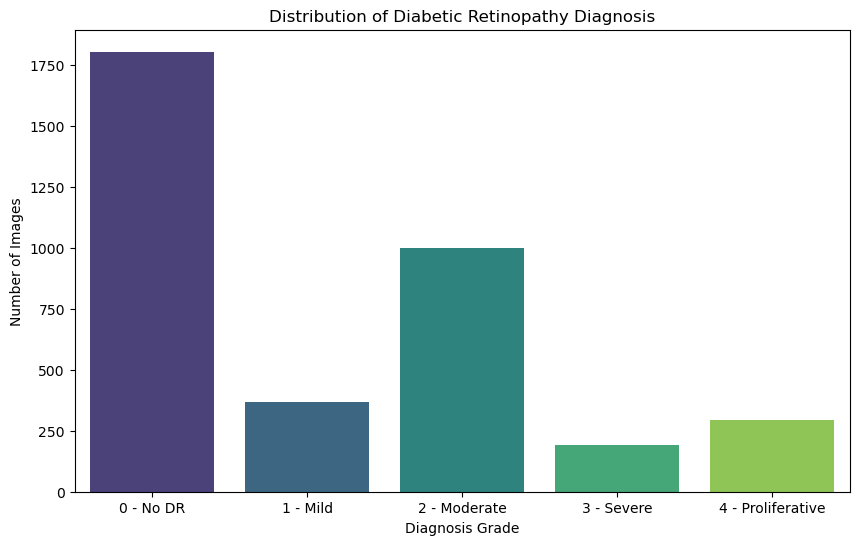

In [1]:
# Import necessary libraries for this step
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a pandas DataFrame
# A DataFrame is essentially a smart spreadsheet for Python.
df = pd.read_csv('train.csv')

# --- Let's explore the DataFrame ---

# 1. Display the first 5 rows to understand the structure
print("First 5 rows of the data:")
print(df.head())
print("\n" + "="*30 + "\n") # Separator for clarity

# 2. Get a summary of the data (columns, data types, etc.)
print("Data information:")
df.info()
print("\n" + "="*30 + "\n")

# 3. This is the most important part: Count the occurrences of each diagnosis
# The diagnosis is graded on a scale of 0 to 4:
# 0 - No DR (Diabetic Retinopathy)
# 1 - Mild
# 2 - Moderate
# 3 - Severe
# 4 - Proliferative DR
diagnosis_counts = df['diagnosis'].value_counts().sort_index()
print("Distribution of Diagnosis Grades:")
print(diagnosis_counts)
print("\n" + "="*30 + "\n")


# --- Let's visualize the distribution ---

# 4. Create a bar plot to visualize the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=diagnosis_counts.index, y=diagnosis_counts.values, palette='viridis')
plt.title('Distribution of Diabetic Retinopathy Diagnosis')
plt.xlabel('Diagnosis Grade')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative'])
plt.show()

Number of healthy images: 1805
Number of images with DR: 1857


Our final balanced dataset:
binary_diagnosis
1    500
0    500
Name: count, dtype: int64




C:\Users\Lijo Sam Raju\AppData\Local\Temp\ipykernel_36084\3662006069.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='binary_diagnosis', data=final_df, palette='pastel')


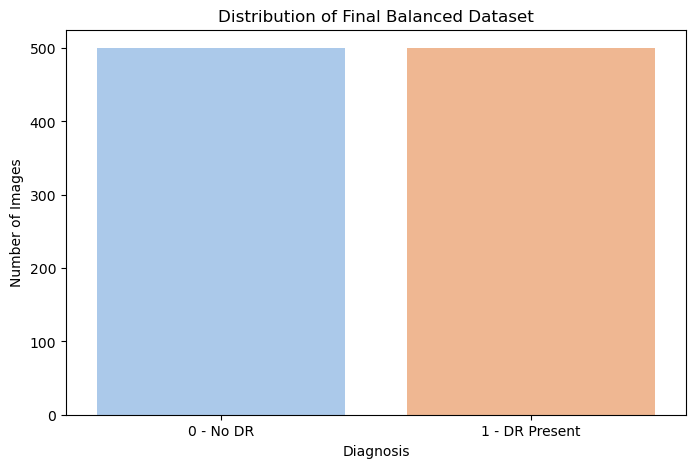

In [3]:
# --- 1. Simplify the problem to a binary classification ---
# We will create a new column 'binary_diagnosis'.
# If the original diagnosis is 0, the new value is 0.
# If the original diagnosis is 1, 2, 3, or 4, the new value is 1.
df['binary_diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x > 0 else 0)


# --- 2. Separate the data into two groups: Healthy (0) and DR Present (1) ---
healthy_df = df[df['binary_diagnosis'] == 0]
dr_present_df = df[df['binary_diagnosis'] == 1]

print(f"Number of healthy images: {len(healthy_df)}")
print(f"Number of images with DR: {len(dr_present_df)}")
print("\n" + "="*30 + "\n")


# --- 3. Create a balanced subset ---
# We'll take a sample of images from each group. Let's start with 500 of each.
# .sample(n) randomly selects 'n' rows. 'random_state' makes sure we get the same
# random sample every time we run the code, which is good for reproducibility.
sample_size = 500
balanced_healthy_df = healthy_df.sample(n=sample_size, random_state=42)
balanced_dr_df = dr_present_df.sample(n=sample_size, random_state=42)

# Combine the two balanced groups into a single final DataFrame
final_df = pd.concat([balanced_healthy_df, balanced_dr_df])

# Shuffle the final DataFrame to mix the 0s and 1s
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Our final balanced dataset:")
print(final_df['binary_diagnosis'].value_counts())
print("\n" + "="*30 + "\n")


# --- Let's visualize our new, balanced distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x='binary_diagnosis', data=final_df, palette='pastel')
plt.title('Distribution of Final Balanced Dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1], labels=['0 - No DR', '1 - DR Present'])
plt.show()

In [5]:
import os
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. Construct the full file paths for each image ---
# We need to tell our program exactly where to find each image.
# We'll create a new column called 'filepath' in our DataFrame.

# Define the base directory where the images are stored
IMAGE_DIR = 'train_images'

# The 'id_code' is the filename without the extension. We'll add '.png'.
# The os.path.join() function is a safe way to combine paths.
final_df['filepath'] = final_df['id_code'].apply(lambda x: os.path.join(IMAGE_DIR, x + '.png'))

# Display the first few rows to see the new 'filepath' column
print("DataFrame with filepaths:")
print(final_df.head())
print("\n" + "="*30 + "\n")


# --- 2. Split the data into training and validation sets ---
# This is a critical step for reliable evaluation.
# We will use 80% of the data for training and 20% for validation.

# We'll split the DataFrame first.
train_df, val_df = train_test_split(
    final_df,
    test_size=0.2,      # 20% of the data will be for validation
    random_state=42,    # Ensures the split is the same every time
    stratify=final_df['binary_diagnosis'] # IMPORTANT: This keeps the 50/50 balance in both train and val sets
)

# Reset the index for the new DataFrames
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# --- 3. Print the results to confirm ---
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")
print("\n" + "="*30 + "\n")

print("Distribution in the training set:")
print(train_df['binary_diagnosis'].value_counts())
print("\n" + "="*30 + "\n")

print("Distribution in the validation set:")
print(val_df['binary_diagnosis'].value_counts())

DataFrame with filepaths:
        id_code  diagnosis  binary_diagnosis                       filepath
0  6b7cf869622a          2                 1  train_images\6b7cf869622a.png
1  36b5b3c9fb32          3                 1  train_images\36b5b3c9fb32.png
2  b376def52ccc          2                 1  train_images\b376def52ccc.png
3  4661006f3ba6          1                 1  train_images\4661006f3ba6.png
4  2a2a6435f7f3          0                 0  train_images\2a2a6435f7f3.png


Number of images in the training set: 800
Number of images in the validation set: 200


Distribution in the training set:
binary_diagnosis
1    400
0    400
Name: count, dtype: int64


Distribution in the validation set:
binary_diagnosis
1    100
0    100
Name: count, dtype: int64


In [7]:
import tensorflow as tf
from tqdm import tqdm # A library to create smart progress bars

# If you don't have tqdm, you might need to install it.
# Open Anaconda Prompt and run: pip install tqdm

# --- 1. Define Image Parameters ---
IMG_SIZE = 224 # We'll resize all images to 224x224

# --- 2. Create a function to process the images ---
def preprocess_image(filepath):
    """
    This function takes a file path, loads the image, decodes it as a 3-channel
    (RGB) image, resizes it, and normalizes the pixel values.
    """
    # Read the file from the filepath
    img = tf.io.read_file(filepath)
    # Decode the image to a 3D tensor (height, width, channels)
    img = tf.image.decode_png(img, channels=3)
    # Resize the image to our desired size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    # Normalize the pixel values to be between 0 and 1
    img = img / 255.0
    return img

# --- 3. Process all the images ---
# We'll create two lists: one for the image data (X) and one for the labels (y).
# tqdm will wrap around our loop to show a progress bar.

print("Processing training images...")
# Create X_train: a list of all processed training images
X_train = []
for filepath in tqdm(train_df['filepath']):
    X_train.append(preprocess_image(filepath))

print("\nProcessing validation images...")
# Create X_val: a list of all processed validation images
X_val = []
for filepath in tqdm(val_df['filepath']):
    X_val.append(preprocess_image(filepath))


# --- 4. Convert lists to NumPy arrays ---
# Neural networks work best with NumPy arrays.
X_train = np.array(X_train)
X_val = np.array(X_val)

# Get the labels from our DataFrames
y_train = train_df['binary_diagnosis'].values
y_val = val_df['binary_diagnosis'].values


# --- 5. Print the final shapes to confirm ---
print("\n" + "="*30 + "\n")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

Processing training images...


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:45<00:00, 17.49it/s]



Processing validation images...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.71it/s]




Shape of X_train: (800, 224, 224, 3)
Shape of y_train: (800,)
Shape of X_val: (200, 224, 224, 3)
Shape of y_val: (200,)


In [9]:
from tensorflow.keras import layers, models

# --- 1. Build the CNN Model ---
# We'll use a sequential model, stacking layers one after another.
model = models.Sequential()

# The input shape now reflects our larger images (224x224)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into the dense layers
model.add(layers.Flatten())

# A dense layer for classification
model.add(layers.Dense(64, activation='relu'))

# *** KEY DIFFERENCE FOR BINARY CLASSIFICATION ***
# The final output layer has only 1 neuron (instead of 10) and uses a 'sigmoid' activation.
# Sigmoid outputs a value between 0 and 1, which is perfect for representing a probability.
model.add(layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


# --- 2. Compile the Model ---
# For binary classification, we use 'binary_crossentropy' as the loss function.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# --- 3. Train the Model ---
# We'll train for 15 epochs. batch_size controls how many images the model
# looks at before updating its weights.
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32, # A standard batch size
    validation_data=(X_val, y_val)
)

C:\Users\Lijo Sam Raju\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,537,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,631,169 (21.48 MB)

 Trainable params: 5,631,169 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 532ms/step - accuracy: 0.7625 - loss: 0.5036 - val_accuracy: 0.8600 - val_loss: 0.2886
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.9200 - loss: 0.2108 - val_accuracy: 0.9250 - val_loss: 0.2335
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.9463 - loss: 0.1869 - val_accuracy: 0.8900 - val_loss: 0.2635
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.9438 - loss: 0.1656 - val_accuracy: 0.9100 - val_loss: 0.2220
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step - accuracy: 0.9588 - loss: 0.1604 - val_accuracy: 0.9350 - val_loss: 0.2255
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 494ms/step - accuracy: 0.9613 - loss: 0.1376 - val_accuracy: 0.9300 - val_loss: 0.2378
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 496ms/step - accuracy: 0.9625 - loss: 0.1390 - val_accuracy: 0.9300 - val_loss: 0.2635
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.9638 - loss: 0.1255 - val_accu

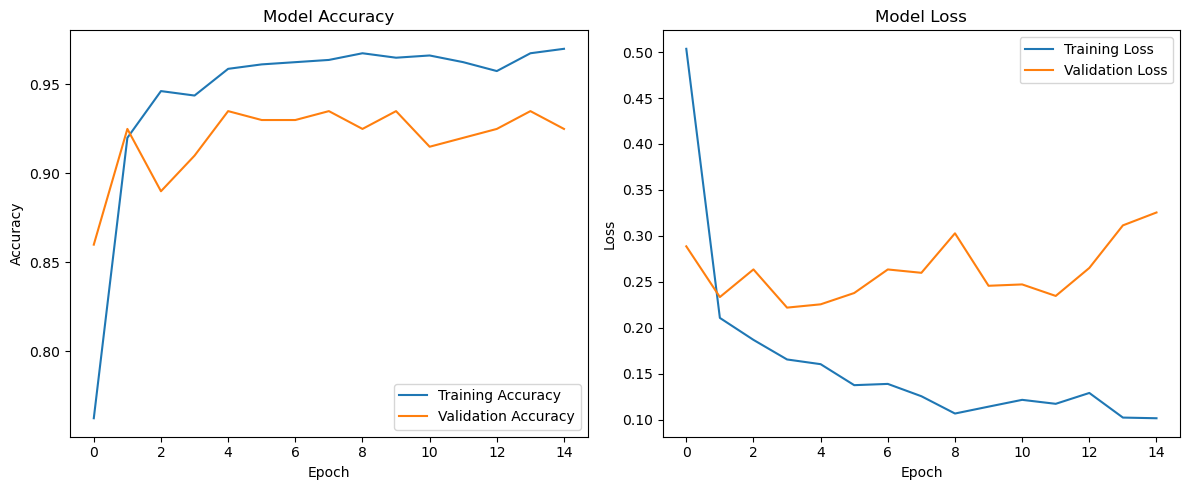

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


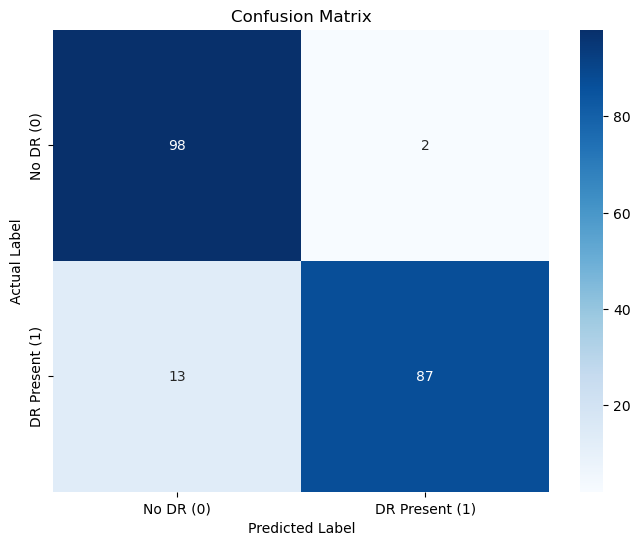


Classification Report:

                precision    recall  f1-score   support

     No DR (0)       0.88      0.98      0.93       100
DR Present (1)       0.98      0.87      0.92       100

      accuracy                           0.93       200
     macro avg       0.93      0.93      0.92       200
  weighted avg       0.93      0.93      0.92       200



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- 1. Plot Training History ---
# Let's visualize the accuracy and loss for the training and validation sets.

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# --- 2. Make Predictions on the Validation Set ---
# We need to get the model's predictions to compare them to the true labels.
# The model outputs probabilities (values between 0 and 1). We'll classify
# anything > 0.5 as 1 (DR Present) and <= 0.5 as 0 (No DR).
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


# --- 3. Generate and Plot a Confusion Matrix ---
# A confusion matrix shows True Negatives, False Positives, False Negatives, and True Positives.
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No DR (0)', 'DR Present (1)'],
            yticklabels=['No DR (0)', 'DR Present (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 4. Print a Classification Report ---
# This report gives detailed metrics for each class.
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=['No DR (0)', 'DR Present (1)']))